In [1]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')

import sys
import os as os 
from glob import glob
import shutil
import numpy as np

import scipy.io as io
import pandas as pd
import seaborn as sns

from nltk.corpus import wordnet as wn
import itertools
from itertools import product
from math import log

from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder

Populating the interactive namespace from numpy and matplotlib


In [2]:
from os.path import basename as bname
from os.path import dirname as dname

from tqdm import tqdm
from taskfunctions import flatten
from taskfunctions import loadimages
from taskfunctions import splitall

In [3]:
def im10k_data():
    '''Generates im10k (pandas Dataframe)\n
       rows = im_names\n
       cols= ['im_name', 'n_pic', 'dir', 'tags', 'vec']\n
       Parameter(s)\n
       ------------\n
       'imdir': top image folder ('images' in cnib)\n
       Variables\n
       ---------\n
       'impaths': list of all image paths (see 'taskfunctions.py')\n
       'im_names': list of all im_names, quantity of images in folder,\
                             folders paths\n
           i.e. 'body_part_dog_tail', 'body_beaver', 'face_bveaver',
                'shoe', 'male_teen' etc.
       'all_tags': ordered list of all possible unique tags\n
       'im10k': conversion of im_names to DF.
                   im10k['tags'].items()
       'matrix': numpy array of category membership for all images
                 For each image, category membership is represented by 1 or 0
                 (1=Category name in path parts; else 0)
       'imdf': conversion from array to DataFrame to create vectors (as rows)\
               for each image\n
       Returns\n
       -------
       'cnib'\n
       *new columns added during execution:\n
           'tags': lists all folders' names (categories) in imdir\n
            'vec': tuple where each boolean value represents\
            category membership\n
            *categories are ordered as 'all_tags'\n
        DATA ACCESS\n
            cnib.loc['concept_name']['datas']['npic', 'dir', 'tags', 'vec']
    '''
    imdir = '../images'
    def get_data():
        impaths = loadimages(imdir)
        im_names = []
        for impath in impaths:
            if 'object' in impath:
                name = bname(dname(impath))
            else:
                name = bname(dname(impath))+' '+\
                                            bname(dname(dname(impath)))
            im_names.append((name, len(os.listdir(dname(impath))),
                             dname(impath)))
        im_names = sorted(list(dict.fromkeys(list(im_names))))
        im10k = pd.DataFrame(im_names, columns=['im_name', 'n_pic', 'dir'])
        im10k.index = im10k.im_name
        im10k['tags'] = [splitall(folderpath[1].split(imdir,
                                                      maxsplit=1)[1])[1:]
                         for folderpath in im10k['dir'].items()]
        all_tags = sorted(list(dict.fromkeys(flatten([tags[1]
                                                      for tags in \
                                                      im10k['tags'].items()]))))
        matrix = np.array([[bool(tags[1].__contains__(tag))
                            for tag in all_tags]
                           for tags in im10k['tags'].items()])
        imdf = pd.DataFrame(matrix, index=im10k['im_name'],
                            columns=all_tags)
        im10k['vec'] = list(row[1] for row in imdf.iterrows())
        im10k = im10k.drop(columns='im_name')
        return im10k
    def categories(im10k, kword):
        '''Categorizes the DF according to neuromod categories using "tags"'''
        return pd.DataFrame([im10k.loc[row[0]]
                             for row in im10k.iterrows()
                             if kword in im10k.loc[row[0]].tags])
    im10k = get_data()
    alltags = sorted(list(dict.fromkeys(flatten(list(im10k.tags)))))
    cnib = pd.DataFrame(zip(alltags, list(categories(im10k, ind)
                                          for ind in tqdm(alltags))),
                        index=alltags, columns=['categories', 'data'])
    cnib = cnib.drop(columns=['categories'])
    return cnib

In [4]:
# data from THINGS
xls = pd.ExcelFile('CogNeuroModels.xlsx')
df_things_data = xls.parse('THINGS')

# sensory-mootor features
xls = pd.ExcelFile('CogNeuroModels.xlsx')
df_LSN_data = xls.parse('LSN')

## To-Do
#### check distribution across animate vs object
#### check distribution across THINGS categories
#### check overlap with THINGS at concept level
#### check overlap with our triplets

### get all the concepts

In [5]:
cnib = im10k_data()

100%|██████████| 411/411 [00:44<00:00,  9.17it/s]


In [6]:
final_all_words = np.hstack((np.unique(np.hstack([np.array(x) for x in cnib.loc['animate']['data']['tags'].values])),
                            np.unique(np.hstack([np.array(x) for x in cnib.loc['object']['data']['tags'].values]))))
df_unique = pd.DataFrame(final_all_words,columns=['Word'])
print('All concepts we have:', df_unique.shape[0])

All concepts we have: 411


In [7]:
df_unique_in_LSN = df_unique[df_unique['Word'].isin([x.lower() for x in df_LSN_data['Word']])]
print('All our concepts that are in LSN:', df_unique_in_LSN.shape[0])

df_unique_in_THINGS = df_unique[df_unique['Word'].isin(df_things_data['Word'])]
tmp = df_things_data[df_things_data['Word'].isin(df_unique_in_THINGS['Word'])]
tmp2 = tmp[tmp['Wordnet ID4'].notna()]
print('All our concepts that are in THINGS and have Wordnet ID:', tmp2.shape[0])

All our concepts that are in LSN: 343
All our concepts that are in THINGS and have Wordnet ID: 272


### compute similarity based on wordnet synset 

In [8]:
sim_mat_wn = np.zeros((len(tmp2),len(tmp2)))

for j in range(0,len(tmp2)):
    for k in range(0,len(tmp2)): 
        s1 = wn.synset(df_things_data[df_things_data['Word']==tmp2.Word.values[j]]['Wordnet ID4'].values[0])
        s2 = wn.synset(df_things_data[df_things_data['Word']==tmp2.Word.values[k]]['Wordnet ID4'].values[0])
        sim_mat_wn[j,k] =  wn.wup_similarity(s1, s2)
        sim_mat_wn[k,j] =  wn.wup_similarity(s1, s2)

### compute t-SNE based on wordnet similarity 

In [9]:
X_wn = 1-(sim_mat_wn)
TSNE = manifold.TSNE(perplexity=30,metric='precomputed', random_state=0)
X_wn_TSNE = TSNE.fit_transform(X_wn)

### plot similarity matrix and t-SNE results 

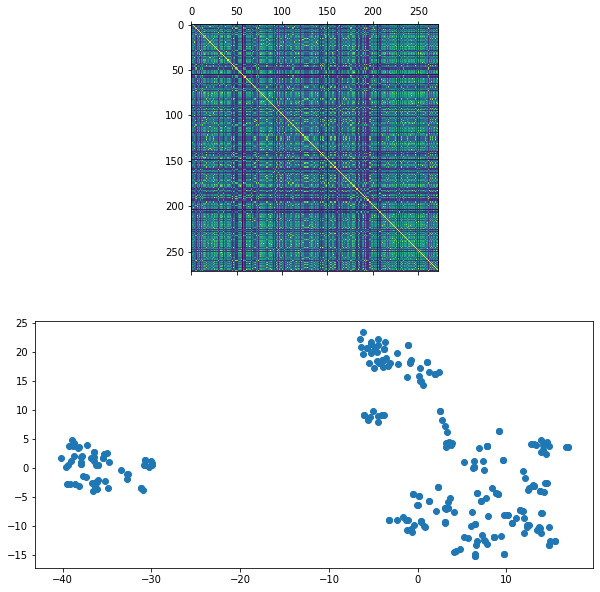

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ax1.matshow(sim_mat_wn) 
#ax1.set_title('WN sim',fontsize= 20)

ax2.scatter(X_wn_TSNE[:, 0], X_wn_TSNE[:, 1])  
#ax2.set_title('WN TSNE',fontsize= 20)

plt.show()

In [28]:
labels_feat = []
# Top-down Category (WordNet)
# All Bottom-up Categories
for w in range(len(tmp2['Top-down Category (WordNet)'])):
    labels_feat.append(tmp2['Top-down Category (WordNet)'].values[w])
le = LabelEncoder()
labels_feat_cat = le.fit_transform(labels_feat)

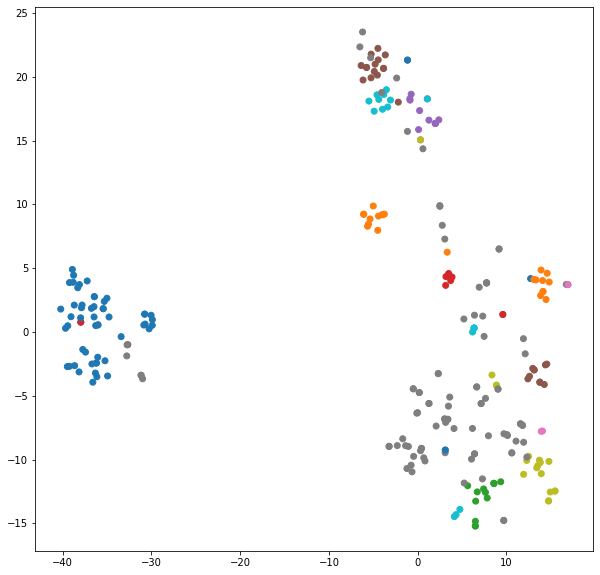

In [50]:
colors_feat = cm.tab10(np.linspace(0, 1, len(np.unique(labels_feat_cat))))

f, (ax1) = plt.subplots(1, 1, figsize=(10,10))

ax1.scatter(X_wn_TSNE[:, 0], X_wn_TSNE[:, 1],
            c=colors_feat[labels_feat_cat[:]])  

plt.show()